1) Для любых пар изображений, которые имеют общее поле зрения (две фотографии, сделанные с телефона, который был повернут на определенный угол - любой лишь бы было 20+% перекрытия), рассчитать матрицу афинного преобразования из одной системы координат в другую. Выполнить разложение данной матрицы и посчитать явно угол поворота, вектор переноса и скалирования. 
Выполнить обратное преобразование - получить афинную матрицу заново. 

Алгоритм:<br>
1. Получаем ключевые точки и дескрипторы точек для двух изображений с помощью sift/orb-детектора.<br>
2. Находим соответствующие друг другу точки на двух картинках по их дескрипторам, используем brute-force matсher.<br>
3. Применяем фильтр по дистанции между соответствующими точками, отбрасываем лишние пары точек по порогу.<br>
4. Вычисляем 2D-матрицу афинного преобразования на основе соответствующих точек двух изображений.<br>
5. Создаем афинную 3D-матрицу, добаляя в третий ряд [0, 0, 1].<br>
6. На основе 3D-матрицы получаем координаты произвольной точки первого изображения на втором.<br>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
import cv2

# extract feature points from image
def extract_img_features(img_gray, method: str):
    if method == 'orb':
        # orinted fast and rotated brief, faster
        detector = cv2.ORB_create()
    else:
        # scale-invariant feature transform, more precisely
        detector = cv2.SIFT_create()

    """ 
    return keypoints structure with:
        pt - (x, y) point coordinates  
        size - diameter of the meaningful neighbors points
        angle - keypoint orientation in clockwise direction
        response - probability of keypoint meaningful
        octave - layer in which keypoint was extracted
        class_id - if cluster objects
    descriptor - keypoint neighborhood description
    """   
    kps, descriptors = detector.detectAndCompute(img_gray, None) 

    return kps, descriptors


In [2]:
# match features between images keypoints
def match_features(descriptor1, descriptor2, k: int, method: str): 
    if method == 'orb':
        matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)       # brute-force matcher
    else:
        matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)

    # k best matches between descriptors
    matches = matcher.knnMatch(descriptor1, descriptor2, k=k)

    return matches


In [3]:
# filter matching points by distance
def distance_filtering(matches, threshold: float):
    filtered_matches = list()

    for m, n in matches:
        if m.distance * 1. / n.distance <= threshold:
            filtered_matches.append(m)

    return filtered_matches


In [4]:
# function to visualize several images in one plot
def visualize_imgs(imgs_list: list, cmap: str = 'viridis'):
    plt.figure(figsize=(20, 16))

    cols = 2
    rows = max(1, int((len(imgs_list) + 0.5) / cols))

    for i, image in enumerate(imgs_list):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap=cmap)


In [5]:
# function for calculate coordinates of point p1(x, y, z) for first image in second image - p2(x, y, z)
def calculate_point2(img1, img2, matrix_3d, p1):
    # draw point p1 on first image
    img1 = cv2.circle(img1, (int(p1[0]), int(p1[1])), 20, (0, 0, 255), -1)

    # calculate point p2 in second image
    p2 = np.dot(matrix_3d, p1)
    print('\nPoint in first image:', p1, '\nPoint in second image:', p2)

    # draw point p2 on second image
    img2 = cv2.circle(img2, (int(p2[0]), int(p2[1])), 20, (0, 0, 255), -1)

    # visualize results to compare
    visualize_imgs([img1, img2])

    return p2


In [7]:
# function to calculate 3D affine matrix
def calculate_affine_matrix_3d(img1_gray, img2_gray, 
                               detection_method: str, distance_threshold: float, 
                               matrix_calc_method: str, visualize: bool = False):
    # extract keypoints and disctiprots from two images
    kps1, des1 = extract_img_features(img1_gray, detection_method)
    kps2, des2 = extract_img_features(img2_gray, detection_method)

    # compare keypoints from two images using their descriptors
    matches = match_features(des1, des2, k=2, method=detection_method)

    # filter points by distance threshold
    filtered_matches = distance_filtering(matches, distance_threshold)

    points_from = np.array([kps1[m.queryIdx].pt for m in filtered_matches])
    points_to = np.array([kps2[m.trainIdx].pt for m in filtered_matches])

    # get 2D affine matrix based on matches points in two images
    if matrix_calc_method == 'estimateAffinePartial2D':
        affine_matrix, _ = cv2.estimateAffinePartial2D(points_from, points_to)
    elif matrix_calc_method == 'findHomography':
        affine_matrix_3d, _ = cv2.findHomography(points_from, points_to, cv2.RANSAC)
    else:
        affine_matrix, _ = cv2.estimateAffine2D(points_from, points_to)

    # extend 2D affine matrix to 3D
    if not matrix_calc_method == 'findHomography':
        affine_matrix_3d = np.append(affine_matrix, [[0, 0, 1]], axis=0)

    if visualize:
        visualize_imgs([img1_gray, img2_gray])

        print('\nMatches count -', len(matches))
        print('Matches count after distance filter -', len(filtered_matches))

        # visualize matches points in two images
        img_matches = cv2.drawMatches(img1_gray, kps1, img2_gray, kps2, 
                                      filtered_matches, None, matchesThickness=3, 
                                      singlePointColor=(125, 200, 100), flags=2)
        visualize_imgs([img_matches])

    return affine_matrix_3d


In [ ]:
# preprocess photos from phone
def preprocess_photos():
    TARGET_RESOLUTION = (1920, 1080)

    for img_path in os.listdir('photos'):
        if img_path.endswith('png'):
            continue

        img = cv2.imread(img_path)

        # calculate scale and redundant height to make proportions 16:9
        scale = TARGET_RESOLUTION[0] / img.shape[1]
        delta_height = int((img.shape[0] - TARGET_RESOLUTION[1] / scale) / 2)

        # resize image crop
        img = cv2.resize(img[delta_height : -delta_height, :, :], TARGET_RESOLUTION, cv2.INTER_CUBIC)

        img_path_new = '.'.join(img_path.split('.')[:-1] + ['png'])
        cv2.imwrite(img_path_new, img)

preprocess_photos()


arget point in second image: (1519, 534, 1)

Matches count - 7789
Matches count after distance filter - 174

Point in first image: (362, 562, 1) 
Point in second image: [1.52093359e+03 5.32482840e+02 1.00000000e+00]
Error: 2.4578 px



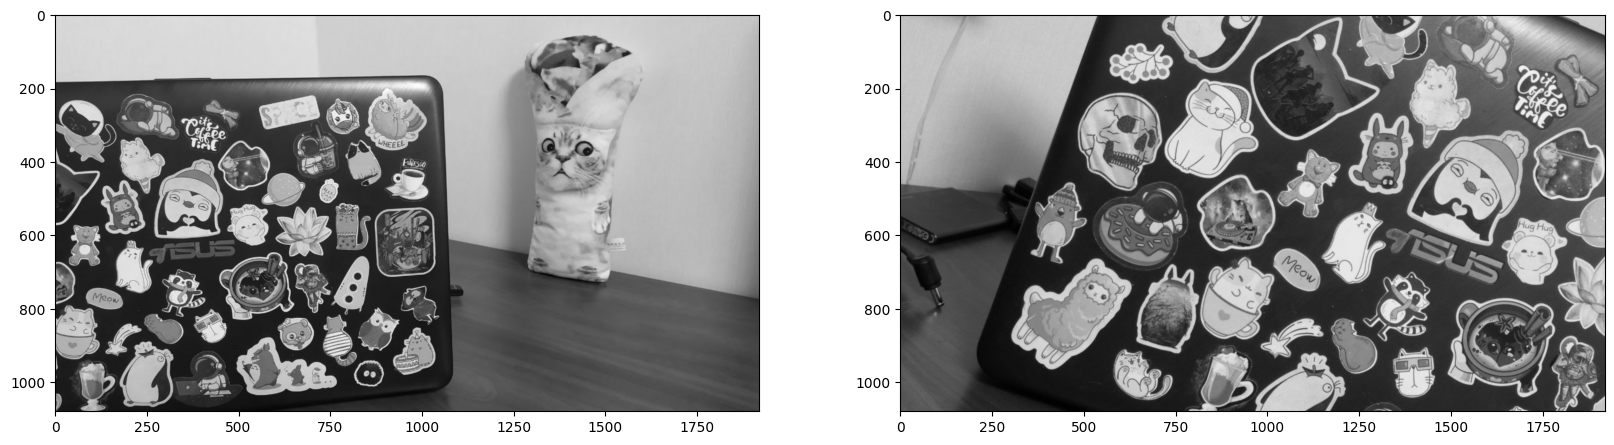

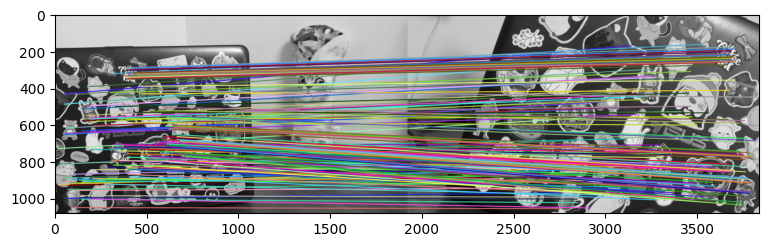

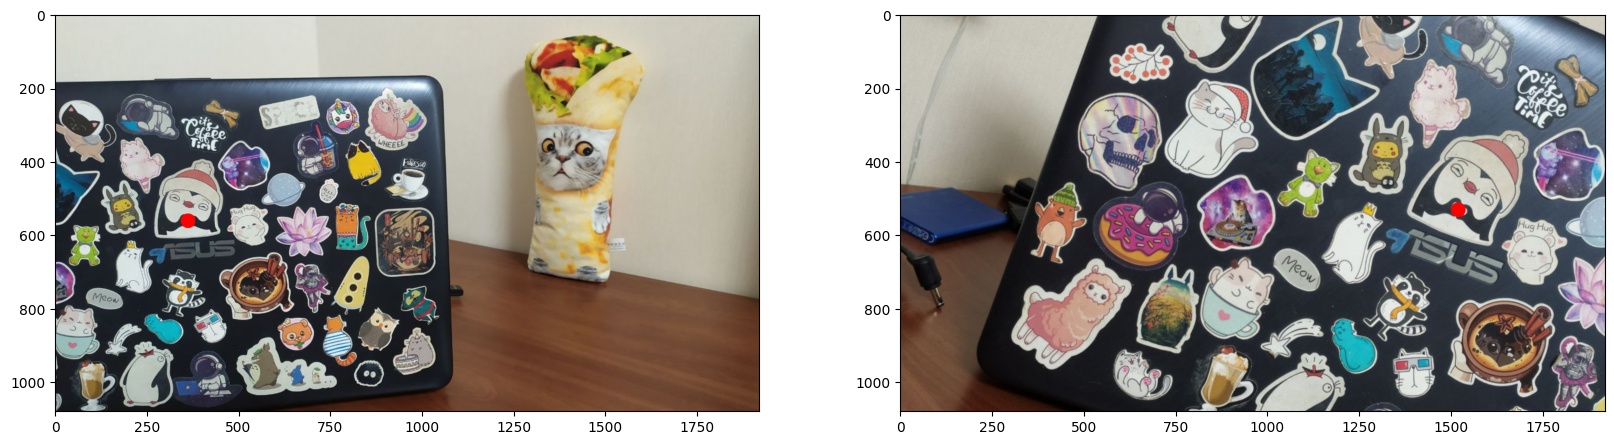

In [9]:
img1_path = 'photos/image_1.png'
img2_path = 'photos/image_2.png'

SIFT_DIST_THRESHOLD = 0.3

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

p1 = (362, 562, 1)
p2_target = (1519, 534, 1)
print('arget point in second image:', p2_target)

affine_matrix_3d = calculate_affine_matrix_3d(img1_gray, img2_gray, detection_method='sift', 
                                              distance_threshold=SIFT_DIST_THRESHOLD, 
                                              matrix_calc_method='estimateAffine2D', visualize=True)

p2 = calculate_point2(img1.copy(), img2.copy(), affine_matrix_3d, p1)
error_dist = np.sqrt((p2[0] - p2_target[0]) ** 2 + (p2[1] - p2_target[1]) ** 2)
print('Error:', round(error_dist, 4), 'px\n')


Раскладывам афинную матрицу на составляющие, затем собираем из составляющих, сравнивам сами матрицы и результат их работы по нахождению точки на втором изображении. 

In [10]:
# function to decompose 3D-matrix
def decompose_matrix(M):
    # translation matrix
    T = M[:2, 2:]

    # scale by OX, scale by OY, than scale matrix
    sx = np.sqrt(M[0, 0] ** 2 + M[1, 0] ** 2)
    sy = np.sqrt(M[0, 1] ** 2 + M[1, 1] ** 2)

    S = np.diag([sx, sy])

    # rotation angle by OZ
    R = M[:2, :2] / np.array([[sx, sx], [sy, sy]])
    thetaZ_rad = np.arctan2(R[1, 0], R[0, 0])
    thetaZ_deg = np.degrees(thetaZ_rad)

    print('Rotation angle, deg:', thetaZ_deg)
    print('\nTranslation matrix:\n', T)
    print('\nScale matrix:\n', S)

    return S, T, R, thetaZ_deg


In [11]:
# function to compose affine 3D-matrix from rotation angle, translation and scale matrices
def recompose_matrix(thetaZ_deg: float, translation_matrix, scale_matrix):
    thetaZ_rad = np.radians(thetaZ_deg)

    # create rotation matrix by OZ
    R = np.array([[np.cos(thetaZ_rad), -np.sin(thetaZ_rad), 0], 
                  [np.sin(thetaZ_rad), np.cos(thetaZ_rad), 0],
                  [0, 0, 1]])

    # create translation 3D-matrix
    T = np.array([[1, 0, translation_matrix[0, 0]], 
                  [0, 1, translation_matrix[1, 0]], 
                  [0, 0, 1]])

    # create scale 3D-matrix
    S = np.diag([scale_matrix[0, 0], scale_matrix[1, 1], 1])

    # return matices multiplication result
    return T @ R @ S


In [12]:
print('INITIAL matrix:\n', affine_matrix_3d, '\n\nDECOMPOSE affine matrix:')

# get 3D affine matrix components
S, T, R, thetaZ_deg = decompose_matrix(affine_matrix_3d)

# create 3D-matrix from components
M_3d = recompose_matrix(thetaZ_deg, T, S)
print('\nRECOMPOSE affine matrix:\n', M_3d, '\n')

# compare recompose matrix with initial
is_close = np.allclose(affine_matrix_3d, M_3d)
print('Are initial and recompose affine matrices simillar?', is_close)


INITIAL matrix:
 [[ 1.28033759e+00 -6.96131768e-01  1.44867743e+03]
 [ 5.89555566e-01  1.40095067e+00 -4.68270552e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

DECOMPOSE affine matrix:
Rotation angle, deg: 22.533469573771296

Translation matrix:
 [[1448.67743489]
 [-468.27055232]]

Scale matrix:
 [[1.40955316 0.        ]
 [0.         1.56437279]]

RECOMPOSE affine matrix:
 [[ 1.30194199e+00 -5.99503720e-01  1.44867743e+03]
 [ 5.40173268e-01  1.44494204e+00 -4.68270552e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

Are initial and recompose affine matrices simillar? False


Как видно из результата метода numpy.allclose(), афинная матрица до разложения и матрица после обратного сложения не совпадают. Проверяем работу второй матрицы на задаче нахождения точки первого изображения на втором. Ниже красным выделена одна и та же точка на двух картинках. Следовательно, собранная афинная матрица работает хуже.


Point in first image: (362, 562, 1) 
Point in second image: [1.58305935e+03 5.39329600e+02 1.00000000e+00]

Target point in second image: (1519, 534, 1) 
Recompose affine matrix error: 64.2807 px



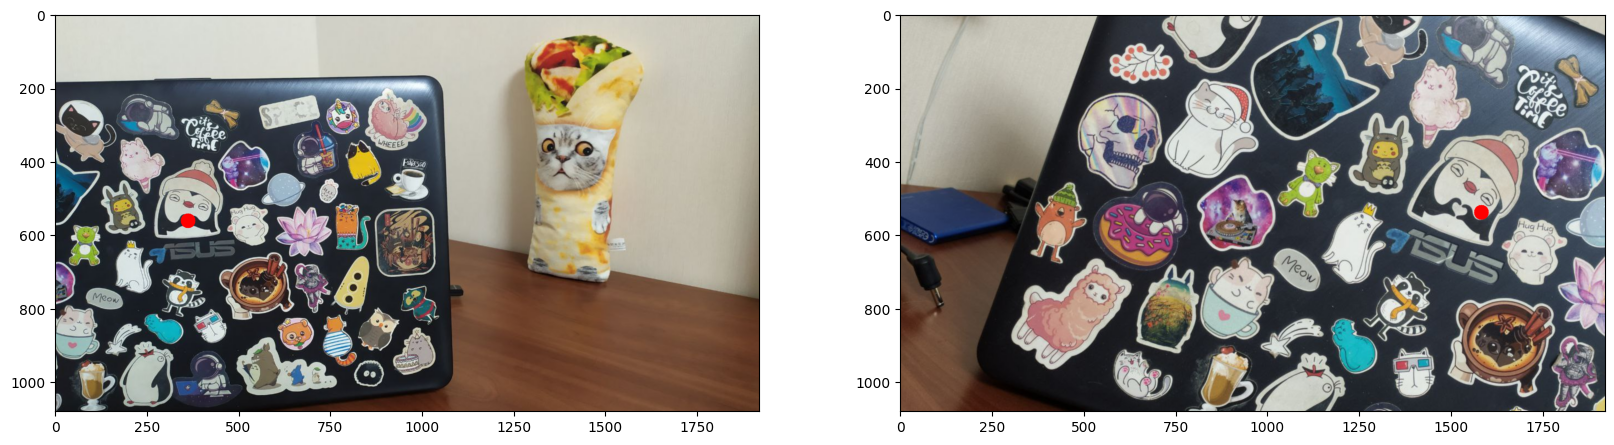

In [13]:
# calculate and visialize p1 point in second image based on recompose 3D affine matrix
p2_recompose = calculate_point2(img1, img2, M_3d, p1)
error_dist = np.sqrt((p2_recompose[0] - p2_target[0]) ** 2 + (p2_recompose[1] - p2_target[1]) ** 2)

print('\nTarget point in second image:', p2_target, 
      '\nRecompose affine matrix error:', round(error_dist, 4), 'px\n')


2) Взять любую видеопоследовательность (желательно вид сверху) - например, полет дрона. Можете скачать из интернета (https://www.youtube.com/@Vaska_pilot/videos) или взять что-то с работы.<br>
Зафиксировав точку (например, центр экрана) выполнить поиск данной точки на последнем кадре с использованием матрицы афинного преобразования 
(считая матрицу между кадрами вы всегда сможете понять где именно находится точка на изображении, а по отклонению самой точки вы можете определить точность самого алгоритма).<br>
Не берите 4к - долго считать, HD будет достаточно.<br>
Посчитать расстояние между точками и ошибку в пикселях.<br>
Попробуйте добавить шум к изображению, посмотрите, как меняется точность (положение точки). <br>
Добавьте фильтр к изображению для улучшения контрастности (любой, который найдете).<br>
Оцените, как влияет выбор метода определения матрицы афинного преобразования - например, estimateAffine2D и его аналоги (аналоги найдите самии).<br>
Оцените, как влияет выбор детектора/дескриптора особых точек на результат. Какой метод даст лучший и самый быстрый результат? 

Алгоритм: <br>
1. Покадрово читаем видео, каждый кадр уменьшаем в три раза.
2. Применяем шум/контраст/ничего к серому изображению.
2. Для каждой пары кадров (предыдущий, текущий) находим совпадающие точки с помощью дескриптора (sift/orb).
4. Вычисляем матрицу афинного преобразования одним из методов.
5. Сохраняем текущий кадр (в сером цвете) как предыдущий для вычислений на следующем шаге.
6. Получаем результирующую матрицу афинного преобразования от первого кадра к последнему перемножением матриц для каждой пары кадров.
7. Составляем таблицу для фиксации параметров работы (время, ошибка) каждого сочетания методов обработки изображений.

Исходное видео находится по ссылке: <a href="https://drive.google.com/file/d/1F25s2XnNQgC-YXrJ9TqP5Luq2PBCiCg3/view?usp=drive_link">source video</a>

In [14]:
# create uniform noise matrix to add to image
def get_noise_matrix(shape):
    h, w = shape

    uniform_noise_matrix = np.zeros((h, w), dtype=np.uint8)
    cv2.randu(uniform_noise_matrix, 0, 255)
    uniform_noise_matrix = (uniform_noise_matrix * 0.5).astype(np.uint8)

    return uniform_noise_matrix


In [15]:
# functin to find point p1 from first video frame in last frame
def processing_video(output_path: str, detection_method: str, distance_th: float,
                     matrix_calc_method: str, p1, 
                     use_noise: bool = False, increase_contrast: bool = False):
    global INPUT_VIDEO_PATH

    # create empty affine matrix to save affine matrices multiplication results from whole video
    general_matrix_3d = np.array([], dtype=float)
    prev_frame_gray = None
    
    # scale for image reduction
    scale = 3
    p1[:2] = [p1[0] / scale, p1[1] / scale]

    cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
    input_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    input_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

    res_width = int(input_width / scale)
    res_height = int(input_height / scale)

    # create video writer to make video with point
    fourcc = cv2.VideoWriter.fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(output_path, fourcc, cap.get(cv2.CAP_PROP_FPS), 
                                   (int(input_width), int(input_height)))
    
    if increase_contrast:   # create Contrast Limited Adaptive Histogram Equation object
        clahe = cv2.createCLAHE()
    elif use_noise:         # noise matrix for frames
        uniform_noise = get_noise_matrix((res_height, res_width))

    while True:
        success, frame = cap.read()

        if not success:
            break

        # convert frame to one-dimential gray image, than resize
        resized_frame_gray = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 
                                        (res_width, res_height), cv2.INTER_CUBIC)
        if increase_contrast:
            resized_frame_gray = clahe.apply(resized_frame_gray)
        elif use_noise:
            resized_frame_gray = cv2.add(resized_frame_gray, uniform_noise)

        if prev_frame_gray is not None:
            # get affine 3D-matrix between two alternate frames
            affine_matrix_3d = calculate_affine_matrix_3d(prev_frame_gray, resized_frame_gray, 
                                                          detection_method=detection_method, 
                                                          distance_threshold=distance_th,
                                                          matrix_calc_method=matrix_calc_method)

            general_matrix_3d = (affine_matrix_3d if general_matrix_3d.size == 0 
                                 else np.dot(affine_matrix_3d, general_matrix_3d))

            # calculate p1 coordinates in current frame, for visualization only
            p2 = np.dot(general_matrix_3d, p1)
            frame = cv2.circle(frame, (int(p2[0] * scale), int(p2[1] * scale)), 
                               10, (0, 0, 255), -1)
        else:
            frame = cv2.circle(frame, (int(p1[0] * scale), int(p1[1] * scale)), 
                               10, (0, 0, 255), -1)
        video_writer.write(frame)

        # save current resized gray frame as previous to calculate affine matrix in next step
        prev_frame_gray = resized_frame_gray

    cap.release()
    video_writer.release()

    # rescale p2 point
    p2[:2] = [p2[0] * scale, p2[1] * scale]

    return p2


Используем равномерный шум, чтобы ухудшить картинку. Пример на первом кадре видео.

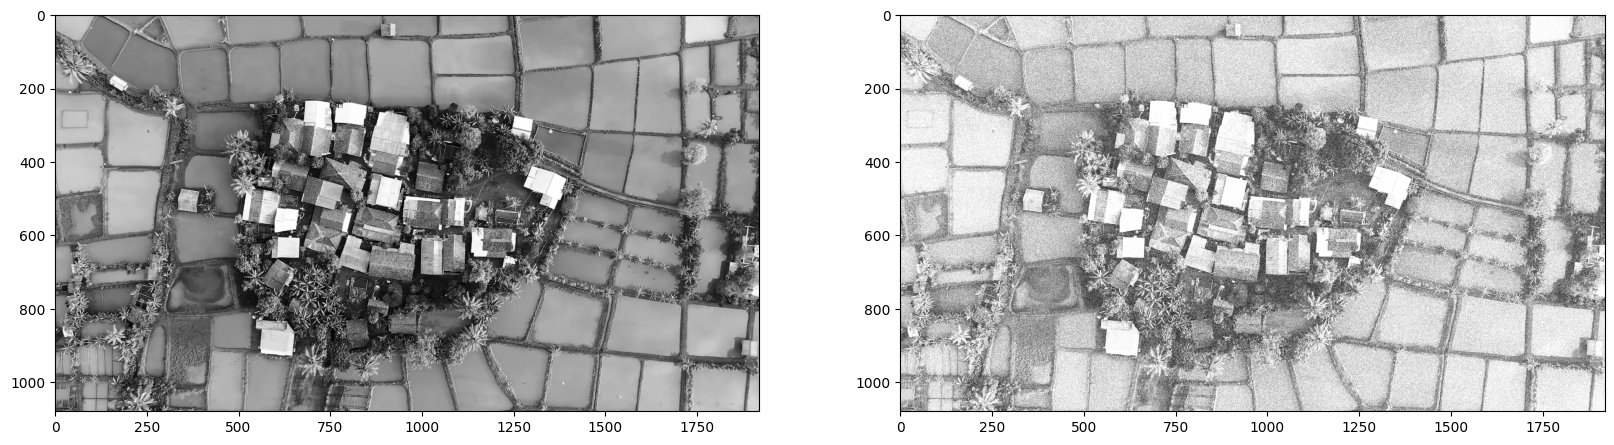

In [16]:
first_frame_path = 'photos/frame_0.png'
img_gray = cv2.imread(first_frame_path, cv2.IMREAD_GRAYSCALE)

h, w = img_gray.shape
img_noise = cv2.add(img_gray, get_noise_matrix((h, w)))

visualize_imgs([img_gray, img_noise])


Используем адаптивную гистограмму с ограничением контраста (CLAHE) для увеличения контраста картинок. Пример на первом кадре видео.

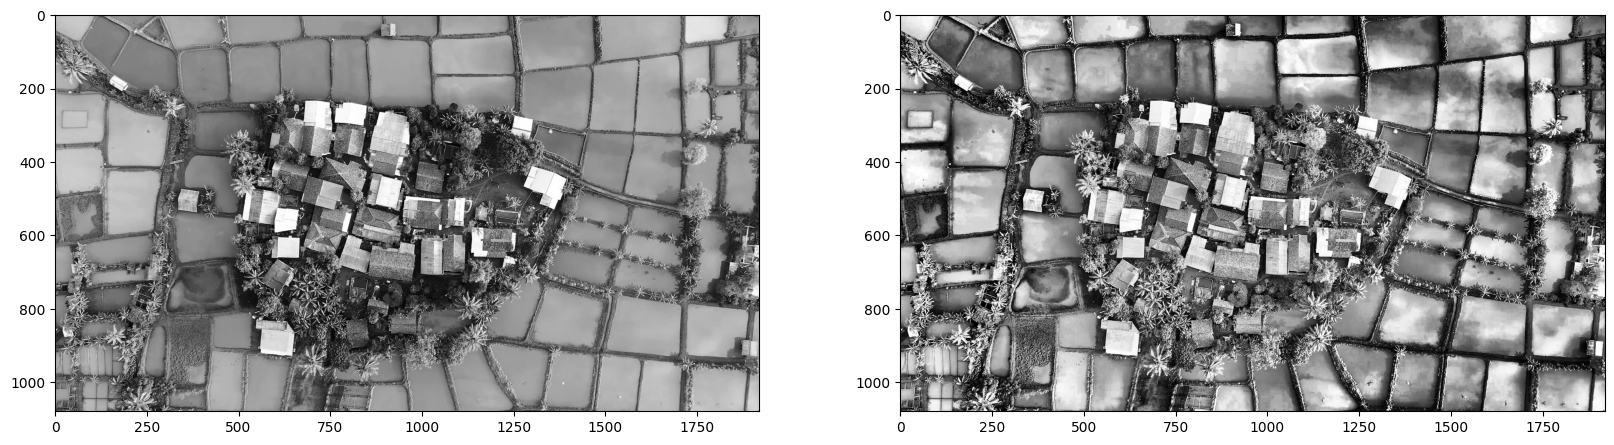

In [17]:
clahe = cv2.createCLAHE()
clahe_gray = clahe.apply(img_gray)

visualize_imgs([img_gray, clahe_gray])


In [ ]:
INPUT_VIDEO_PATH = 'source_video.mp4'
OUTPUT_VIDEO_PATH = '/media/vik/SamsungSSD7/Courses/peleng-cources/videos/video_with_point'

df_columns = ['Descriptor method', 'Noise', 'Contrast', 'Matrix calculation method', 'Time,s', 'Error,px']
analyze_df = pd.DataFrame(columns=df_columns)
df_file_path = 'video_analyze.xlsx'

# create dictionary for different methods threshold
dist_th_dict = {'orb': 0.8, 'sift': 0.2}

# methods of calculation affine matrix
matrix_calc_detection_methods = ['estimateAffinePartial2D', 'estimateAffine2D', 'findHomography']

p1 = [1430, 470, 1]
p2_target = [1020, 400, 1]

for use_noise, use_contrast in [[False, False], [True, False], [False, True]]:
    for detection_method, dist in dist_th_dict.items():
        for matrix_method in matrix_calc_detection_methods:
            print(detection_method.upper(), 'method', ('with noise' if use_noise else 'without noise'),
                ('with contrast' if use_contrast else 'without contrast'), 'with', matrix_method)

            output_path = OUTPUT_VIDEO_PATH + '_' + detection_method.upper() + '_' + matrix_method + \
                ('_noise' if use_noise else '') + ('_contrast' if use_contrast else '') + '.mp4'

            start_t = time.time()
            p2 = processing_video(output_path, detection_method, dist, matrix_calc_method=matrix_method,
                                  p1=p1.copy(), use_noise=use_noise, increase_contrast=use_contrast)
            delta_t = round(time.time() - start_t, 4)

            # distance between point coordinates in two images
            points_dist = np.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)

            # method error
            error_dist = np.sqrt((p2[0] - p2_target[0]) ** 2 + (p2[1] - p2_target[1]) ** 2)

            df_row = [detection_method, use_noise, use_contrast, matrix_method, 
                      delta_t, round(error_dist, 4)]

            if analyze_df.empty:
                analyze_df = pd.DataFrame([df_row], colmns=df_columns)
            else:
                analyze_df = analyze_df._append(dict(zip(df_columns, df_row)), ignore_index=True)

analyze_df.to_excel(df_file_path, index=False)


In [19]:
analyze_df

Descriptor method  Noise  Contrast Matrix calculation method     Time,s  \
0                orb  False     False   estimateAffinePartial2D   130.7900   
1                orb  False     False          estimateAffine2D   116.7881   
2                orb  False     False            findHomography   119.2480   
3               sift  False     False   estimateAffinePartial2D   663.6796   
4               sift  False     False          estimateAffine2D   848.9630   
5               sift  False     False            findHomography   943.4219   
6                orb   True     False   estimateAffinePartial2D   159.7055   
7                orb   True     False          estimateAffine2D   159.3167   
8                orb   True     False            findHomography   158.9266   
9               sift   True     False   estimateAffinePartial2D   920.4333   
10              sift   True     False          estimateAffine2D   902.9002   
11              sift   True     False            findHomography   911.0300   
12               orb  False      True   estimateAffinePartial2D   160.9641   
13               orb  False      True          estimateAffine2D   166.4494   
14               orb  False      True            findHomography   163.3576   
15              sift  False      True   estimateAffinePartial2D  1213.7730   
16              sift  False      True          estimateAffine2D  1275.7291   
17              sift  False      True            findHomography  1236.4111   

     Error,px  
0    601.1347  
1    822.3269  
2   2409.6331  
3     62.3509  
4     37.5903  
5    613.9972  
6    423.7493  
7    586.0155  
8   1617.4300  
9    159.1950  
10   159.2629  
11  1839.2551  
12   379.6248  
13   542.3521  
14  2253.5728  
15    70.1277  
16    87.2471  
17  1111.8270

Из таблицы видно, что самым точным оказалось сочетание дескриптора точек sift с методом определения матрицы estimateAffine2D без шума и контраста, однако самым медленным. <a href="https://drive.google.com/file/d/1ommtyCWnntssn381VHNQxE1GoPzYkfW9/view?usp=drive_link">Ссылка на видео</a><br>
Самым быстрым оказалось сочетание дескриптора точек orb с методом определения матрицы estimateAffine2D без шума и контраста, но и самым неточным.<br><br> 
При применении шума самым точным оказалось сочетание дескриптора точек sift с методом определения матрицы estimateAffinePartial2D, однако практически самым медленным. <a href="https://drive.google.com/file/d/1B96Zvego1aWlyM44cBKGj7Ibjq7swT9a/view?usp=drive_link">Ссылка на видео</a><br>
Самым быстрым и неточным при приминении шума было сочетание дескриптора точек orb с методом определения матрицы findHomography, точка была потеряна за пределами кадра.<br><br>
При применении контраста самым точным оказалось сочетание дескриптора точек sift с методом определения матрицы estimateAffinePartial2D, однако практически самым медленным. <a href="https://drive.google.com/file/d/15nfW17rC2GKcnijwm-Dc1JpW2IsecaXO/view?usp=drive_link">Ссылка на видео</a><br>
Самым быстрым и неточным при приминении шума было сочетание дескриптора точек orb с методом определения матрицы findHomography, точка была потеряна за пределами кадра.<br><br>	
По точности результата для данной задачи подходит дескриптор sift с методами определения матрицы estimateAffine2D и estimateAffinePartial2D. 

При анализе видео на gpu с использованием LoFTR мы уступаем дескриптору sift в скорости и точности:<br>
LoFTR time - 853.0437s, error - 8166.7404px<br>
<a href="https://drive.google.com/file/d/1QOdriw0K1zrhfpbtlGOuyO6DLy-FxxeR/view?usp=drive_link">Ссылка на видео</a>

Обработанные видео с лучшими результатами находятся по ссылке: <a href="https://drive.google.com/drive/folders/1gVo-hB7sS4dqxTarq3v5c2LGhZpLmjvC?usp=drive_link">output videos</a>